In [26]:
import numpy as np

import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

import scipy.signal as signal
from scipy.fft import fft

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [2]:
def fill_trailing_zeros_with_max(arr):
    result = arr.copy()
    for i, row in enumerate(result):
        max_val = np.max(row)
        
        # Find indices of non-zero elements
        nonzero_indices = np.nonzero(row)[0]
        
        if len(nonzero_indices) > 0:
            # Get the index after the last non-zero element
            last_nonzero_idx = nonzero_indices[-1]
            # Fill trailing zeros
            result[i, last_nonzero_idx + 1:] = max_val
    
    return result


def apply_padding(array, padding_length, position="left", paddign_value=0):
    padding_base = np.ones((array.shape[0], padding_length))

    if type(paddign_value) is not int and type(paddign_value) is not float: 
        if len(paddign_value) != array.shape[0]:
            raise ValueError("Padding value must match the number of columns in the array.")
        else:
            padding = (padding_base.T * paddign_value).T
    else:
        padding = padding_base * paddign_value

    if position == "left":
        return np.concatenate((padding, array), axis=1)
    elif position == "right":
        return np.concatenate((array, padding), axis=1)
    elif position == "both":
        return np.concatenate((padding, array, padding), axis=1)
    else:
        raise ValueError("Position must be 'left', 'right', or 'both'.")

In [3]:
# open the file with energy depositions
max_len = 1600
n_signals = 5

energy_depositions = np.zeros((n_signals, max_len))

dict_signals = {}

with open("signals_gesim.txt", "r") as f:
    for line in f:
        kay = str(line.strip()[0:8])
        val = line.strip()[11:-1]
        dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail


In [4]:
q = 1.6e-19
W = 1
R = 10000e9

current = np.gradient(energy_depositions_padded, axis=1)/W * q  # in A
voltage = current * R

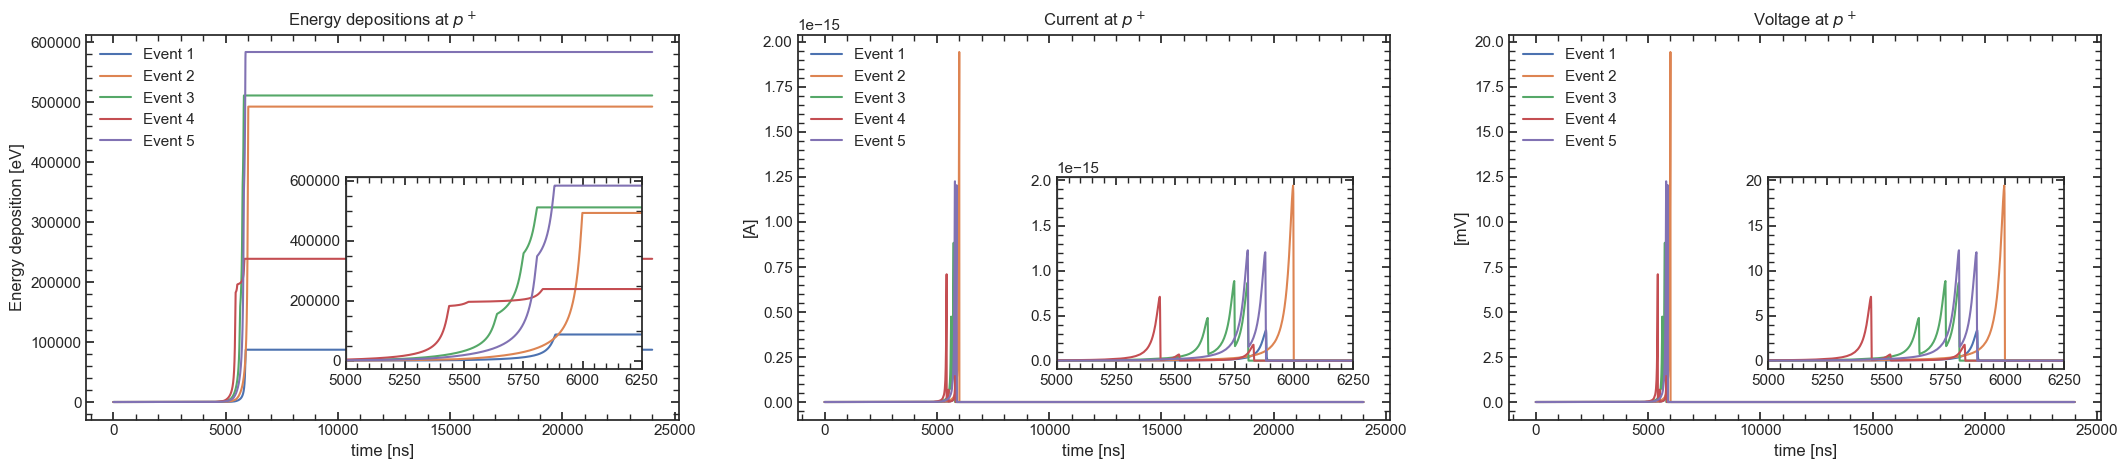

In [5]:
plt.figure(figsize=(26, 5))  

plt.subplot(1, 3, 1)
plt.title("Energy depositions at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("Energy deposition [eV]")

for i in range(n_signals):
    plt.plot(energy_depositions_padded[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(energy_depositions_padded[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 2)
plt.title("Current at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[A]")

for i in range(n_signals):
    plt.plot(current[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(current[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 3)
plt.title("Voltage at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[mV]")

for i in range(n_signals):
    plt.plot(voltage[i]*1e3, label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(voltage[i]*1e3, label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

-------

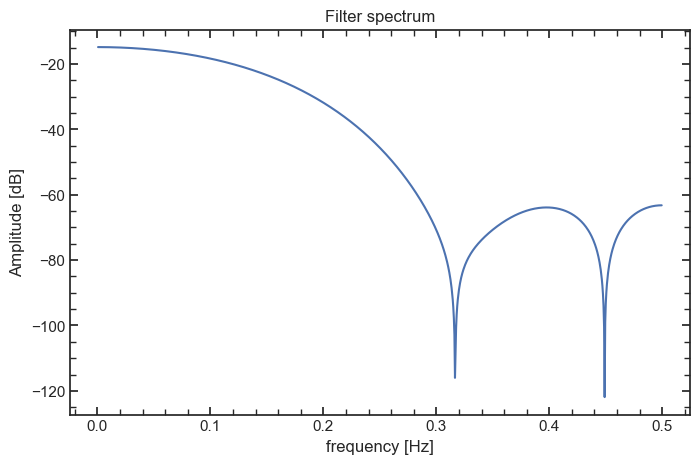

In [6]:
def spectrum(wf,points=int(1000),fs=1):
    """
    Computes the frequency spectrum of a waveform.
    
    Args:
        wf (array): waveform
        points (int): number of points in the psd
        fs (int): sampling frequency
        
    Returns:
        array: frequency
        array: amplitude
        array: phase
    """
    spect = fft(wf,n=2*(points-1),axis=0)
    amp = np.abs(spect/fs/len(wf))
    amp = amp[:int(len(spect)/2+1)]
    amp[1:] = 2*amp[1:]
    phase = np.angle(spect[:int(len(spect)/2+1)])
    freq=np.arange(0,fs/2,fs/2/len(amp))
    return freq,amp,phase

f_h = 15e6 # Hz
f_s = 62.5e6 # Hz

w_h = 2 * np.pi * f_h
w_s = 2 * np.pi * f_s

low_len = 11 # Length of the FIR filter
f_cut = f_h/f_s # Relative Cut frequency for the filter


filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='hamming')
freq, amp, __ = spectrum(filter, points=1000)

plt.figure(figsize=(8, 5))
plt.title("Filter spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.plot(freq[1:], 20*np.log10(amp[1:]), label="Filter response");


In [12]:
def cc4(detector_signal, dt, units="ADC", add_noise=True, freq_response=True, f_h=15e6, calibration_applied=True):

    ADC_to_V = 0.13/(20e3)
    V_to_ADC = 1/ADC_to_V
    ADC_bias = 15000

    R_f = 1e9
    C_f = 400e-15
    dc_bias = -3.52

    with open('total_transfer_function_params.pkl', 'rb') as f:
        total_transfer_loaded = pickle.load(f)

    with open('calibration_curve_params.pkl', 'rb') as f:
        calibration_curve_loaded = pickle.load(f)

    def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
            tau = R_f * C_f             
            offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
            output_signal = np.zeros_like(input_signal)
            effective_signal = input_signal - offset  

            if decay:
                decay_factor = np.exp(-dt /tau)
            else: decay_factor = 1

            for i in range(1, len(input_signal)):
                input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
                output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
            
            return -output_signal

    if freq_response:
        f_s = 62.5e6 

        low_len = 11 
        f_cut = f_h/f_s 

        filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='hamming')

    waveforms = np.zeros(detector_signal.shape)

    for i in range(detector_signal.shape[0]):
        input_signal = detector_signal[i,:] + dc_bias
        output_csa = total_transfer_loaded(input_signal)
        integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
        if calibration_applied:
            conversion = calibration_curve_loaded(integrated_signal)
            waveforms[i,:] = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
        else:
            waveforms[i,:] = integrated_signal

        if add_noise:
            sigma = 0.0002
            noise = np.random.normal(0, sigma, detector_signal.shape[1])
            waveforms[i,:] += noise

        if freq_response:
            waveforms[i,:] = np.convolve(waveforms[i,:], filter)[:-low_len+1] 

    if units == "ADC":
        return (waveforms * V_to_ADC) + ADC_bias    
    elif units == "V":
        return waveforms 
    else:
        raise ValueError("Units must be 'ADC' or 'V'.")


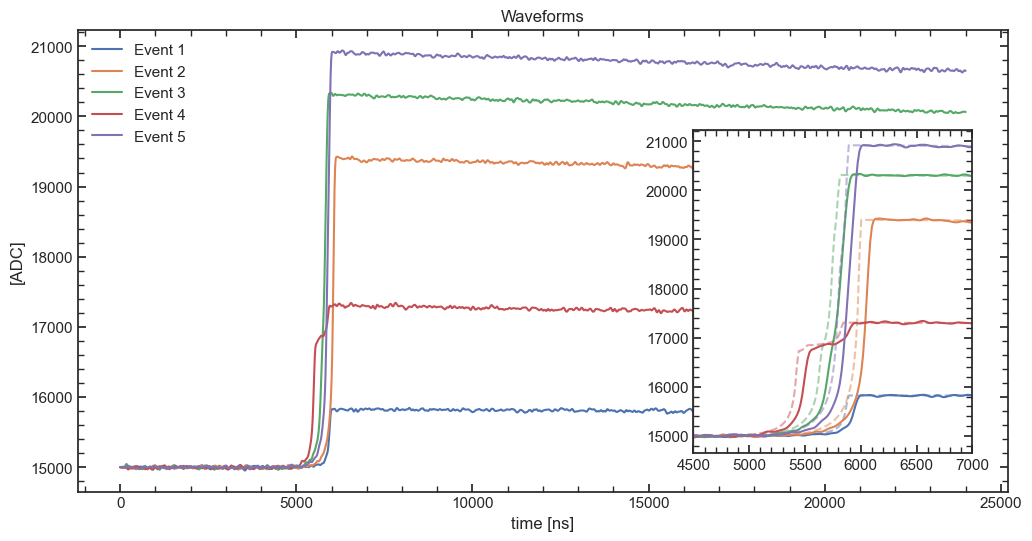

In [8]:
signal_sampled = voltage[:, ::16]
time = np.linspace(0, (max_len + 22400)*1e-9, 1500) # ns
dt = time[1] - time[0]


waveforms = cc4(signal_sampled, dt, units="ADC", add_noise=True, freq_response=True)
waveforms_no_filter = cc4(signal_sampled, dt, units="ADC", add_noise=False, freq_response=False)


plt.figure(figsize=(12, 6))  
plt.title("Waveforms")
plt.xlabel("time [ns]")
plt.ylabel("[ADC]")

for i in range(n_signals):
    plt.plot(time*1e9, waveforms[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="30%", 
                    height="70%", 
                    bbox_to_anchor=(-0.03, -0.2, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    line1 = axins.plot(time*1e9, waveforms[i])
    color = line1[0].get_color()
    axins.plot(time*1e9, waveforms_no_filter[i], ls ='--', color=color, alpha=0.5)

axins.set_xlim(4500, 7000)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()


In [ ]:
df_pulser = pd.read_pickle("pulser_dataframe.pkl")


,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[4.315062048411276e-09, 3.696958565803581e-08,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[3.760714285713948e-05, 3.110714285713948e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.004638,1.512630e-11
1,1,1.716273e+09,"[2.6424179794069536e-07, -3.5533422514424417e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[7.707142857137115e-06, 1.2071428571371145e-06...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.014515,1.341216e-10
2,2,1.716273e+09,"[4.120732642532984e-08, -4.062282534129105e-08...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[-3.8164285714286054e-05, -5.7664285714286054e...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.022909,3.253645e-10
3,8,1.716272e+09,"[3.6657959838365994e-07, -5.581256948365801e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.771071428571395e-05, 5.121071428571395e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.032431,6.397754e-10
4,5,1.716272e+09,"[-7.574683244446494e-07, -1.0437785225215877e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.4460714285713954e-05, 6.746071428571396e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.045656,1.416528e-09
5,13,1.716272e+09,"[-4.620886801066035e-07, 1.6080686067715828e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[1.5042857142862886e-05, 4.754285714286289e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.072507,3.377835e-09
6,3,1.716272e+09,"[1.0843543790409398e-06, -1.847590937678603e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-1.8385714285718678e-05, -3.788571428571868e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.091233,5.529557e-09
7,7,1.716272e+09,"[2.6072058841550167e-07, 6.708428623276273e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-8.171428571427897e-06, -1.6714285714278958e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.114635,8.766474e-09
8,10,1.716271e+09,"[1.3476253681308756e-06, 4.27295848431496e-07,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[4.039285714286052e-06, -1.5460714285713948e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.128655,1.036040e-08
9,9,1.716271e+09,"[1.7606980586735308e-06, 6.020718390996616e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[5.065357142856738e-05, 6.365357142856738e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.161716,1.578049e-08


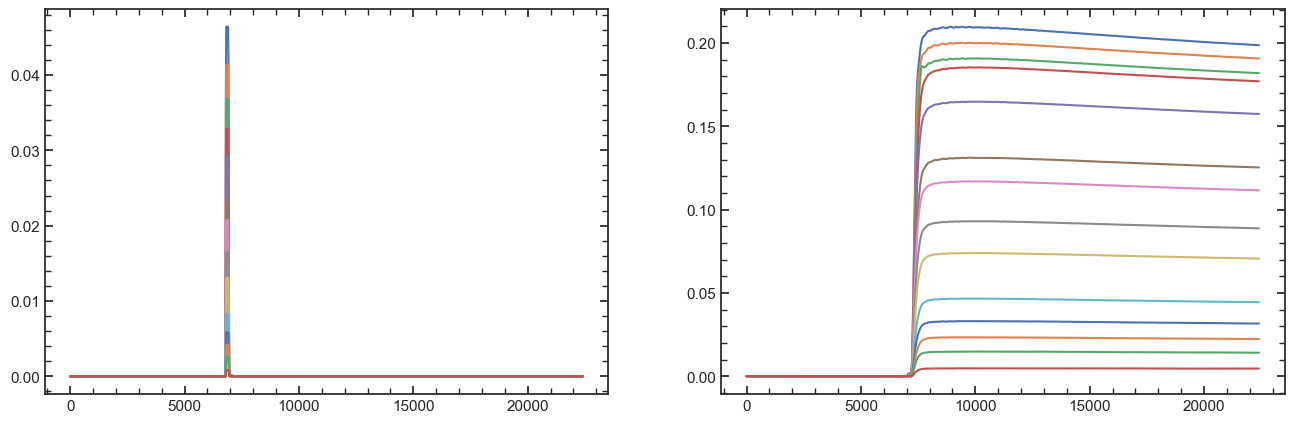

In [14]:
time_signal = np.array(df_pulser["time_signal"][0])*1e-9


plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
for i in range(len(df_pulser))[::-1]:
    plt.plot(time_signal*1e9, df_pulser["signal"][i] )

plt.subplot(1, 2, 2)
for i in range(len(df_pulser))[::-1]:
    plt.plot(time_signal*1e9, df_pulser["waveform"][i])

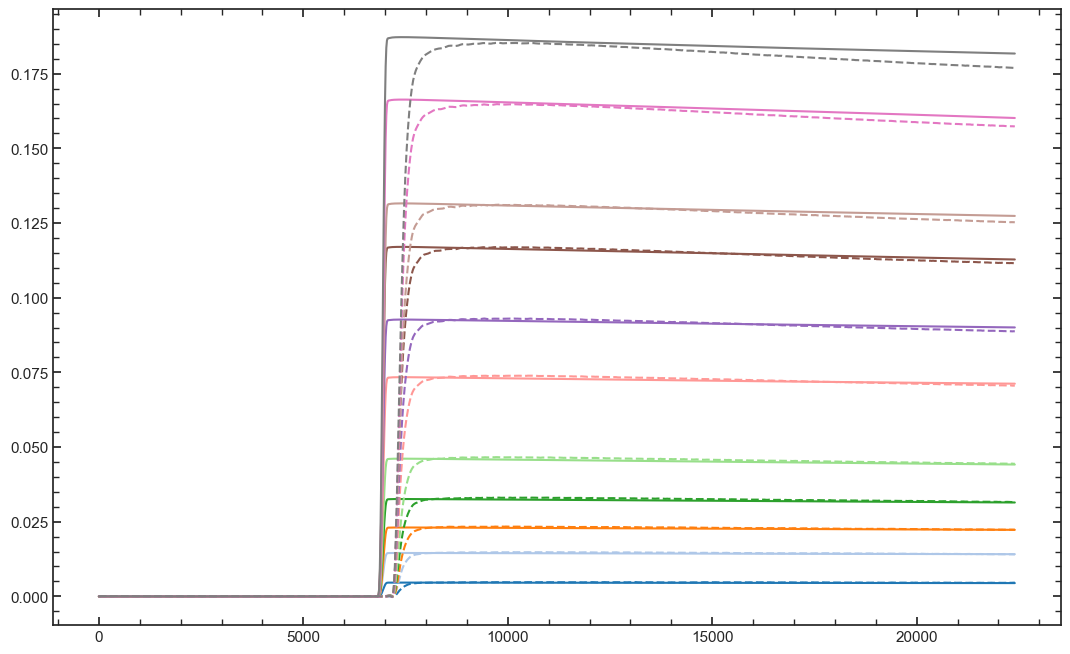

In [34]:
n_waveforms = int(len(df_pulser)-3)

pulser_data = np.zeros((n_waveforms, len(time_signal)))

for i in range(n_waveforms):
    pulser_data[i] = df_pulser["signal"][i]


dt_signal = time_signal[1] - time_signal[0]
pulser_waveforms = cc4(pulser_data, dt_signal, units="V", add_noise=False, freq_response=True, calibration_applied=True)





plt.figure(figsize=(13, 8))
cmap = cm.get_cmap('tab20') 
colors = [cmap(i / len(df_pulser)) for i in range(len(df_pulser))]

for i in range(n_waveforms):
    color = colors[i]
    plt.plot(time_signal*1e9, pulser_waveforms[i], label=f"Event {i+1}", color=color)
    plt.plot(time_signal*1e9, df_pulser["waveform"][i], ls='--', color=color)

